<a href="https://colab.research.google.com/github/thenovicenafi/thenovicenafi/blob/main/Experimenting_with_CNN_Components_What_Actually_Matters%3F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Why This Notebook Exists

I was confused about CNN components and wanted to actually *understand*
them. So I built this experiments to
answer questions that bugged me:

**My Questions:**
- Does adding more layers always improve accuracy?
- How much do feature maps actually matter?
- What's the "optimal" architecture for MNIST?

**My Approach:**
- ✅ Controlled experiments (change one variable at a time)
- ✅ Proper reproducibility (fixed seeds)
- ✅ Clear documentation and visualization
- ✅ Honest analysis of what works and what doesn't

**Standing on the Shoulders of Giants:**

This work builds upon excellent tutorials:
- [How to Choose CNN Architecture - MNIST](https://www.kaggle.com/code/cdeotte/how-to-choose-cnn-architecture-mnist) by Chris Deotte
- [Convolutional Neural Network Tutorial](https://www.kaggle.com/code/kanncaa1/convolutional-neural-network-cnn-tutorial) by Kaan

**What's Different Here:**
Rather than just following along, I systematically tested multiple
configurations, documented surprises (like why 2 layers beat 3!),
and made everything reproducible for others to learn from.

* * *

*This is a learning project documenting my journey to understand
CNN architecture.*

                                                                    ⚠️⚠️⚠️⚠️

**Disclaimer:** <br> Throughout these experiments, some models may exhibit overfitting. This notebook focuses on understanding the *relative* impact of different CNN components under controlled conditions as a learning exercise, with regularization techniques like dropout explored later.

                                                                    ⚠️⚠️⚠️⚠️

### Check and Set

I used dataset from kaggel [digit-mnist kaggle](https://www.kaggle.com/competitions/digit-recognizer). You can download it then save to your google drive or save it on your disk. You can also use kaggle notebooks to try

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("GPU Devices:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
Num GPUs Available: 1
GPU Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
!ls "/content/drive/MyDrive/Colab Notebooks/Hello world AI/dataset/digit-recognizer.zip"

'/content/drive/MyDrive/Colab Notebooks/Hello world AI/dataset/digit-recognizer.zip'


In [ ]:
import zipfile
import os

path_to_zip_file = '/content/drive/MyDrive/Colab Notebooks/Hello world AI/dataset/digit-recognizer.zip'
directory_to_extract_to = '/content/drive/MyDrive/Colab Notebooks/Hello world AI/dataset/digit-recognizer'

os.makedirs(directory_to_extract_to, exist_ok=True)

with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

print(f"Files extracted to: {directory_to_extract_to}")

Files extracted to: /content/drive/MyDrive/Colab Notebooks/Hello world AI/dataset/digit-recognizer


                                                            🍅⭐🍅⭐🍅

# 1. Convolutional Neural Networks (CNN) In A Nutshell

CNN are deep learning models designed to process data with a grid-like topology such as images. CNN design begins with feature extraction and end up with classification.
> The architecture : image -> convolutional layers -> pooling -> convolutional layers -> pooling . . . -> flatten -> dense (fully connected)

Feature extraction: convolution layers with pooling layers <br>
Classification: dense layers with final softmax layers

#### First Step

In [ ]:
#import dependencies
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns

In [ ]:
#Add seed to ensures that this randomness can be controlled and replicated
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Hello world AI/dataset/digit-recognizer/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Hello world AI/dataset/digit-recognizer/test.csv")

#get label for ground truth
Y_train = train["label"]
#drop lable and get pixels column. We'll use this to throw for the models
X_train = train.drop(labels = ["label"], axis = 1)
#normalization
X_train = X_train / 255.0
X_test = test / 255.0
#reshape
X_train = X_train.values.reshape(-1, 28, 28, 1)
X_test = X_test.values.reshape(-1, 28, 28, 1)
#make integer label to one hot encoding [1, 0, 0, 0, 0, 0, 0, 0, 0, 0] mean 1
Y_train = to_categorical(Y_train, num_classes = 10)

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)
styles=[':','-.','--','-',':','-.','--','-',':','-.','--','-']

# 2. Experimenting with CNN Components

To understand how different components affect CNN performance,
we'll conduct systematic experiments on MNIST dataset

## 2.1 Convolutional Layers: Does Depth Matter?

To know how much convo layers that we need for our model we should looking for pixel of our input image.

In [ ]:
print(X_train.shape)

(42000, 28, 28, 1)


So, we know that we have 28x28 pixel image or 784 pixel. We can try to use 1, 2, or 3 convolutional layers:
* 784 - [24C5-P2] - 256 - 10
* 784 - [24C5-P2] - [48C5-P2] - 256 - 10
* 784 - [24C5-P2] - [48C5-P2] - [64C5-P2] - 256 - 10
<br>
We increase the number of feature maps for each subsequent pair so that CNN can learn more complex feature in deep layer, even the image become smaller after pooling

In [ ]:
networks = 3
model = [0] * networks

for net in range(3):
    model[net] = Sequential()
    model[net].add(Conv2D(24, kernel_size=5, padding='same', activation='relu', input_shape=(28, 28, 1)))
    model[net].add(MaxPool2D())
    if net>0:
        model[net].add(Conv2D(48, kernel_size=5, padding='same', activation='relu', input_shape=(28, 28, 1)))
        model[net].add(MaxPool2D())
    if net>1:
        model[net].add(Conv2D(64, kernel_size=5, padding='same', activation='relu', input_shape=(28, 28, 1)))
        model[net].add(MaxPool2D())
    model[net].add(Flatten())
    model[net].add(Dense(256, activation='relu'))
    model[net].add(Dense(10, activation='softmax'))
    model[net].compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
for net in range(networks):
    print(f"\n=== Model {net+1} Summary ===")
    model[net].summary()


=== Model 1 Summary ===


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 24)     │           624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4704)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     1,204,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,207,674 (4.61 MB)

 Trainable params: 1,207,674 (4.61 MB)

 Non-trainable params: 0 (0.00 B)


=== Model 2 Summary ===


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 24)     │           624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 14, 14, 48)     │        28,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 7, 7, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 2352)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       602,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 634,410 (2.42 MB)

 Trainable params: 634,410 (2.42 MB)

 Non-trainable params: 0 (0.00 B)


=== Model 3 Summary ===


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 24)     │           624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 14, 14, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 14, 14, 48)     │        28,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 7, 7, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 7, 7, 64)       │        76,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 256,618 (1002.41 KB)

 Trainable params: 256,618 (1002.41 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Create Validation Set
X_train2, X_val2, Y_train2, Y_val2 = train_test_split(X_train, Y_train, test_size = 0.333, random_state=seed)

#Train networks
history = [0] * networks
names = ["(C-P)x1","(C-P)x2","(C-P)x3"]
epoch = 20
for net in range(networks):
    history[net] = model[net].fit(X_train2, Y_train2, batch_size= 80, epochs= epoch,
    validation_data = (X_val2, Y_val2), callbacks= [annealer], verbose=0)
    print("CNN {0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(names [net], epoch, max(history[net].history['accuracy']), max(history[net].history['val_accuracy'])))

CNN (C-P)x1: Epochs=20, Train accuracy=1.00000, Validation accuracy=0.98799
CNN (C-P)x2: Epochs=20, Train accuracy=1.00000, Validation accuracy=0.99213
CNN (C-P)x3: Epochs=20, Train accuracy=1.00000, Validation accuracy=0.99156


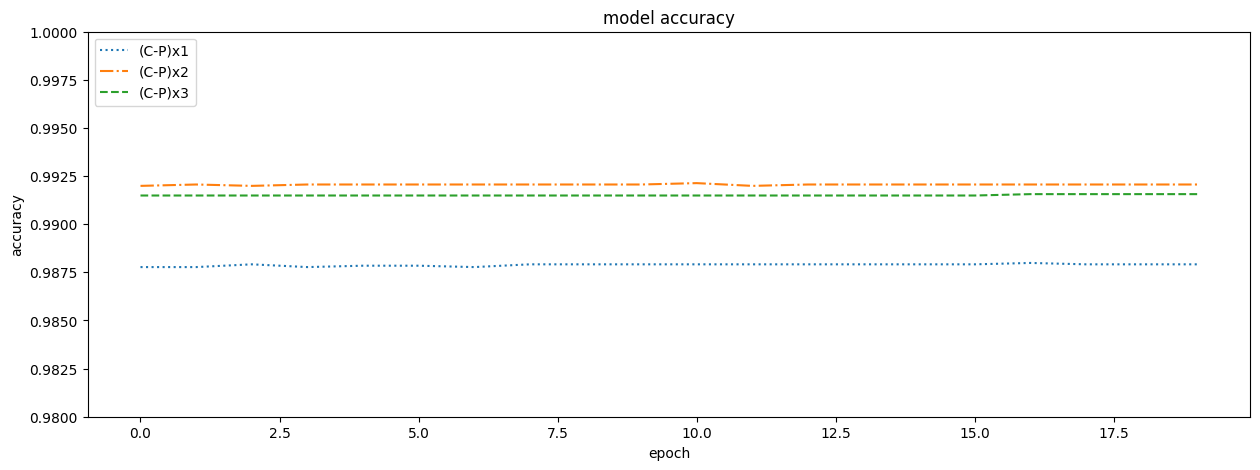

In [ ]:
plt.figure(figsize=(15,5))
for net in range(networks):
    plt.plot(history[net].history['val_accuracy'],linestyle=styles[net])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(names, loc='upper left')
axes = plt.gca()
axes.set_ylim([0.98,1])
plt.show()

**Insight:** <br>
Two convolutional layers provide the best performance for MNIST.
A single layer lacks sufficient feature hierarchy, while three layers show
diminishing returns likely due to over-parameterization for this simple task.
This confirms that optimal architecture depends on task complexity, not just
*more is better*. That's why 2 layers hit the *sweet spot* for this task

## 2.2 Feature Maps: Impact of Filter Configuration

Feature maps capture specific patterns and characteristics from the input.
From the previous results, **Model 2 (2 conv layers) achieved the best
performance at 99.2% accuracy**. However, could different feature map
configurations change these results?

**Experiment:**
- **Model 1:** Test with 16, 32, 64, 128 filters
- **Model 2:** Test with [16->32], [32->64], [64->128] filters  
- **Model 3:** Test with [16->32->64], [32->64->128], [64->128->254] filters

Let's find out if Model 2's advantage holds across all configurations!

In [ ]:
def filter_maps(conv_layers, filter_lists):
    model = Sequential()

    model.add(Conv2D(filter_lists[0], kernel_size=5, padding="same", activation="relu", input_shape=(28, 28, 1)))
    model.add(MaxPool2D())

    for nets in range(1, conv_layers):
        if nets < len(filter_lists):
            model.add(Conv2D(filter_lists[nets], kernel_size=5, padding='same', activation="relu"))
            model.add(MaxPool2D())
        else:
            print(f"Warning: Not enough filters provided for {conv_layers} convolutional layers.")
            break

    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(Dense(10, activation="softmax"))

    model.compile(optimizer= "adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [ ]:
experiments = [
    #model 1
    {'name': 'M1_f16', 'layers': 1, 'filters': [16]},
    {'name': 'M1_f32', 'layers': 1, 'filters': [32]},
    {'name': 'M1_f64', 'layers': 1, 'filters': [64]},

    #model 2
    {'name': 'M2_f16-32', 'layers': 2, 'filters': [16, 32]},
    {'name': 'M2_f32-64', 'layers': 2, 'filters': [32, 64]},
    {'name': 'M2_f64-128', 'layers': 2, 'filters': [64, 128]},

    #model 3
    {'name': 'M3_f16-32-64', 'layers': 3, 'filters': [16, 32, 64]},
    {'name': 'M3_f32-64-128', 'layers': 3, 'filters': [32, 64, 128]},
    {'name': 'M3_f64-128-256', 'layers': 3, 'filters': [64, 128, 256]},
]

#train
results = {}
for exp in tqdm(experiments, desc="All Experiments"):
    print(f"\nTraining {exp['name']} with filters {exp['filters']}")
    model = filter_maps(exp['layers'], exp['filters'])
    history = model.fit(X_train2, Y_train2, batch_size=80, epochs=epoch, validation_data=(X_val2, Y_val2), callbacks=[annealer], verbose= 2)
    results[exp['name']] = history

All Experiments:   0%|          | 0/9 [00:00<?, ?it/s]


Training M1_f16 with filters [16]
Epoch 1/20
351/351 - 5s - 14ms/step - accuracy: 0.9173 - loss: 0.2810 - val_accuracy: 0.9698 - val_loss: 0.1065 - learning_rate: 1.0000e-03
Epoch 2/20
351/351 - 2s - 5ms/step - accuracy: 0.9759 - loss: 0.0808 - val_accuracy: 0.9796 - val_loss: 0.0668 - learning_rate: 9.5000e-04
Epoch 3/20
351/351 - 2s - 5ms/step - accuracy: 0.9856 - loss: 0.0496 - val_accuracy: 0.9822 - val_loss: 0.0568 - learning_rate: 9.0250e-04
Epoch 4/20
351/351 - 1s - 4ms/step - accuracy: 0.9902 - loss: 0.0332 - val_accuracy: 0.9837 - val_loss: 0.0526 - learning_rate: 8.5737e-04
Epoch 5/20
351/351 - 1s - 4ms/step - accuracy: 0.9936 - loss: 0.0225 - val_accuracy: 0.9829 - val_loss: 0.0596 - learning_rate: 8.1451e-04
Epoch 6/20
351/351 - 1s - 4ms/step - accuracy: 0.9963 - loss: 0.0159 - val_accuracy: 0.9829 - val_loss: 0.0562 - learning_rate: 7.7378e-04
Epoch 7/20
351/351 - 1s - 4ms/step - accuracy: 0.9975 - loss: 0.0109 - val_accuracy: 0.9845 - val_loss: 0.0547 - learning_rate: 7.

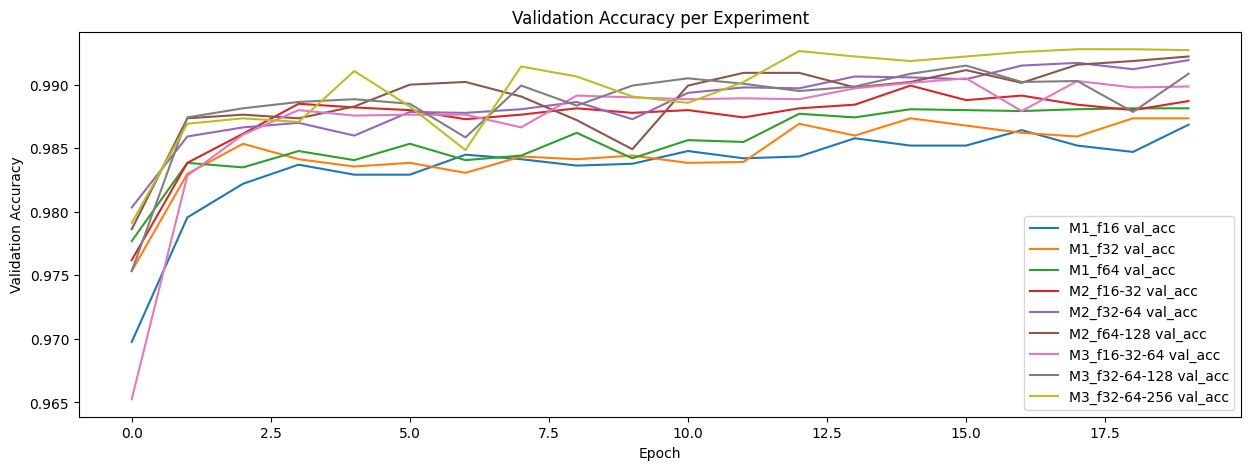

In [ ]:
plt.figure(figsize=(15,5))

for name, history in results.items():
    plt.plot(history.history['val_accuracy'], label=f"{name} val_acc")

plt.title("Validation Accuracy per Experiment")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.show()

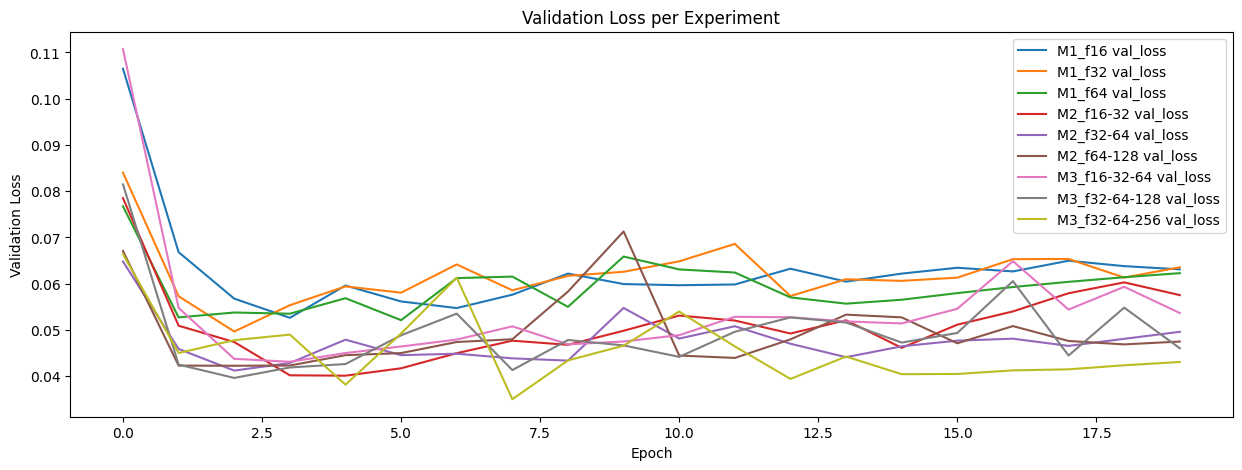

In [ ]:
plt.figure(figsize=(15,5))

for name, history in results.items():
    plt.plot(history.history['val_loss'], label=f"{name} val_loss")

plt.title("Validation Loss per Experiment")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.legend()
plt.show()

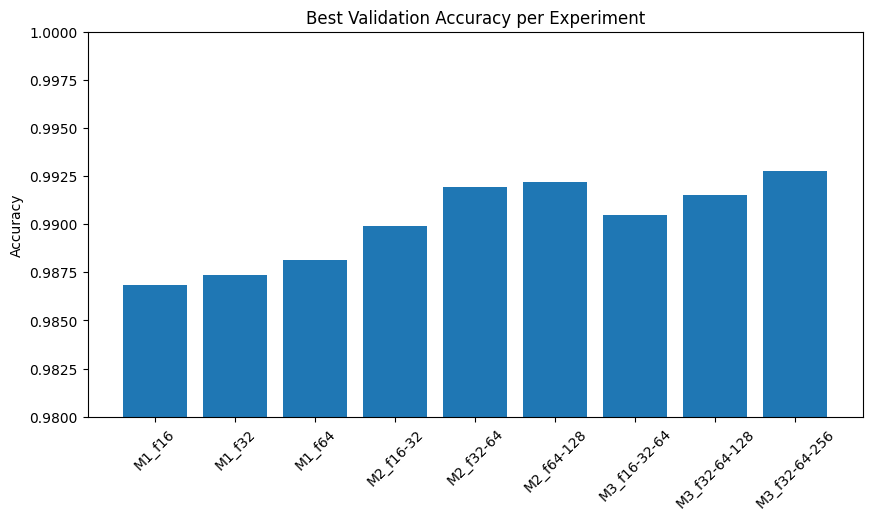

In [ ]:
final_scores = {name: max(h.history['val_accuracy']) for name, h in results.items()}

plt.figure(figsize=(10,5))

plt.ylim(0.98, 1.0)
plt.bar(final_scores.keys(), final_scores.values())
plt.title("Best Validation Accuracy per Experiment")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.show()

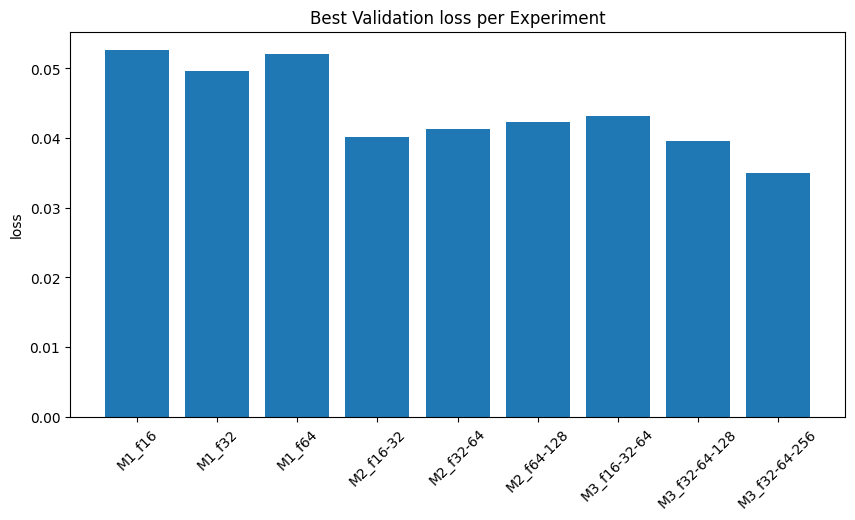

In [ ]:
final_scores = {name: min(h.history['val_loss']) for name, h in results.items()}

plt.figure(figsize=(10,5))
plt.bar(final_scores.keys(), final_scores.values())
plt.title("Best Validation loss per Experiment")
plt.ylabel("loss")
plt.xticks(rotation=45)
plt.show()

let's looking for the best feature map for every model each layer

In [ ]:
rows = []
for name, hist in results.items():
    h = hist.history
    best_acc = np.max(h['val_accuracy'])
    best_loss = np.min(h['val_loss'])
    layers = int(name[1])
    rows.append([name, layers, best_acc, best_loss])

df = pd.DataFrame(rows, columns=['name', 'layers', 'best_val_acc', 'best_val_loss'])

best_by_layers = df.loc[df.groupby('layers')['best_val_acc'].idxmax()]
print(best_by_layers)

            name  layers  best_val_acc  best_val_loss
2         M1_f64       1      0.988131       0.052128
5     M2_f64-128       2      0.992207       0.042275
8  M3_f32-64-256       3      0.992778       0.035038


The best feature map for every model: <br>
*   Model with a convolutional layer good at 64 feature maps
*   Model with 2 convolutional layer good at [64->128] feature maps
*   Model with 3 convolutional layer good at [64->128->256] feature maps
<br>
We will use this for next experiment

**Insight:** <br>
Feature map configuration significantly impacts model performance, deeper architectures showing greater sensitivity to filter sizing. The
optimal configuration (3 layers, 32->64->256 filters) outperforms all
other tested combinations, demonstrating that **proper feature map tuning
is essential for realizing the benefits of deeper architectures**. Architecture depth and feature map size must be optimized together.
Deeper models need proper tuning to shine.

## 2.3 Dense Layer: How Large a Dense Layer?

Dense layers a.k.a Fully Connected (FC) each of the neurons in these layers is connected to every *activation* in the previous layer creating highly interconnected network. In our previous experiment, we decided on <br> model 1 : 784 - [64C5-P2] - 256 - 10, <br> model 2: 784 - [64C5P-P2] - [128C5-P2] - 256 - 10 , <br> model 3: 784 - [64C5-P2] - [128C5-P2] - [256C5-P2] - 256 - 10

We'll try some dense layers units: <br>
from 0, 32, 64, 128, 256, 512, 1024, 2048 in every model that win

Model 1

In [ ]:
dense_units = [0, 32, 64, 128, 256, 512, 1024, 2048]
models_m1 = {}
histories_m1 = {}

nets = 1
for units in dense_units:
    model = Sequential()
    model.add(Conv2D(64, kernel_size=5, padding="same", activation="relu", input_shape=(28, 28, 1)))
    model.add(MaxPool2D())

    model.add(Flatten())
    if units > 0:
        model.add(Dense(units, activation="relu"))

    model.add(Dense(10, activation="softmax"))
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    models_m1[f"M{nets}_D{units}"] = model

    # Split training data for validation
    X_train2, X_val2, Y_train2, Y_val2 = train_test_split(X_train, Y_train, test_size = 0.333, random_state=seed)

    # Training
    history = model.fit(X_train2, Y_train2, epochs=20, batch_size=80,
                       validation_data=(X_val2, Y_val2), verbose=2, callbacks=[annealer])

    histories_m1[f"M{nets}_D{units}"] = history

    print(f"\n✓ Model M{nets}_D{units} selesai ditraining\n")

Epoch 1/20
351/351 - 5s - 13ms/step - accuracy: 0.9096 - loss: 0.3152 - val_accuracy: 0.9663 - val_loss: 0.1219 - learning_rate: 1.0000e-03
Epoch 2/20
351/351 - 1s - 4ms/step - accuracy: 0.9717 - loss: 0.0986 - val_accuracy: 0.9774 - val_loss: 0.0781 - learning_rate: 9.5000e-04
Epoch 3/20
351/351 - 2s - 5ms/step - accuracy: 0.9814 - loss: 0.0666 - val_accuracy: 0.9803 - val_loss: 0.0652 - learning_rate: 9.0250e-04
Epoch 4/20
351/351 - 2s - 5ms/step - accuracy: 0.9857 - loss: 0.0508 - val_accuracy: 0.9826 - val_loss: 0.0607 - learning_rate: 8.5737e-04
Epoch 5/20
351/351 - 1s - 4ms/step - accuracy: 0.9887 - loss: 0.0409 - val_accuracy: 0.9837 - val_loss: 0.0592 - learning_rate: 8.1451e-04
Epoch 6/20
351/351 - 1s - 4ms/step - accuracy: 0.9908 - loss: 0.0337 - val_accuracy: 0.9837 - val_loss: 0.0584 - learning_rate: 7.7378e-04
Epoch 7/20
351/351 - 1s - 4ms/step - accuracy: 0.9926 - loss: 0.0281 - val_accuracy: 0.9838 - val_loss: 0.0581 - learning_rate: 7.3509e-04
Epoch 8/20
351/351 - 1s - 

Model 2

In [ ]:
models_m2 = {}
histories_m2 = {}

nets = 2
for units in dense_units:
    model = Sequential()
    model.add(Conv2D(64, kernel_size=5, padding="same", activation="relu", input_shape=(28, 28, 1)))
    model.add(MaxPool2D())

    model.add(Flatten())
    if units > 0:
        model.add(Dense(units, activation="relu"))

    model.add(Dense(10, activation="softmax"))
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    models_m2[f"M{nets}_D{units}"] = model

    # Split training data for validation
    X_train_split, X_val, Y_train_split, Y_val = train_test_split(X_train, Y_train, test_size=0.333, random_state=seed)

    # Training
    history = model.fit(X_train_split, Y_train_split, epochs=20, batch_size=80,
                       validation_data=(X_val, Y_val), verbose=0, callbacks=[annealer])

    histories_m2[f"M{nets}_D{units}"] = history

    print(f"\n✓ Model M{nets}_D{units} selesai ditraining\n")


✓ Model M2_D0 selesai ditraining


✓ Model M2_D32 selesai ditraining


✓ Model M2_D64 selesai ditraining


✓ Model M2_D128 selesai ditraining


✓ Model M2_D256 selesai ditraining


✓ Model M2_D512 selesai ditraining


✓ Model M2_D1024 selesai ditraining


✓ Model M2_D2048 selesai ditraining



In [ ]:
Model 3

In [ ]:
models_m3 = {}
histories_m3 = {}

nets = 3
for units in dense_units:
    model = Sequential()
    model.add(Conv2D(64, kernel_size=5, padding="same", activation="relu", input_shape=(28, 28, 1)))
    model.add(MaxPool2D())

    model.add(Conv2D(128, kernel_size=5, padding='same', activation="relu"))
    model.add(MaxPool2D())

    model.add(Flatten())
    if units > 0:
        model.add(Dense(units, activation="relu"))

    model.add(Dense(10, activation="softmax"))
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    models_m3[f"M{nets}_D{units}"] = model

    # Split training data for validation
    X_train_split, X_val, Y_train_split, Y_val = train_test_split(X_train, Y_train, test_size=0.333, random_state=seed)

    # Training
    history = model.fit(X_train_split, Y_train_split, epochs=20, batch_size=80,
                       validation_data=(X_val, Y_val), verbose=0, callbacks=[annealer]) # Changed verbose to 0

    histories_m3[f"M{nets}_D{units}"] = history

    print(f"\n✓ Model M{nets}_D{units} selesai ditraining\n")


✓ Model M3_D0 selesai ditraining


✓ Model M3_D32 selesai ditraining


✓ Model M3_D64 selesai ditraining


✓ Model M3_D128 selesai ditraining


✓ Model M3_D256 selesai ditraining


✓ Model M3_D512 selesai ditraining


✓ Model M3_D1024 selesai ditraining


✓ Model M3_D2048 selesai ditraining



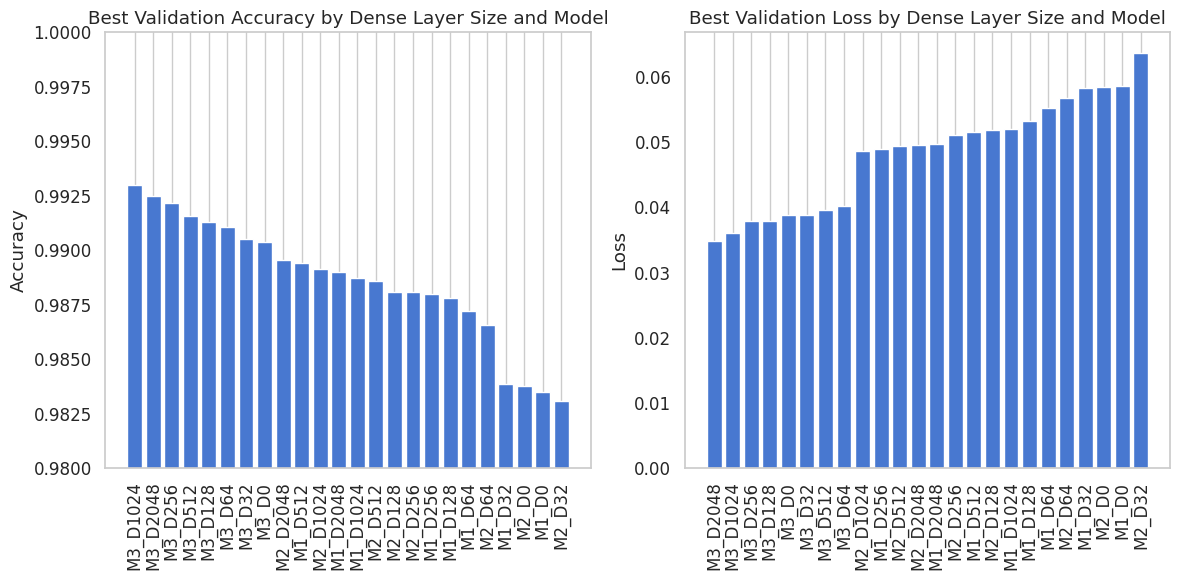

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

sns.set(style="whitegrid", palette="muted", font_scale=1.1)

final_acc_scores = {name: max(h.history['val_accuracy']) for name, h in all_histories.items()}
final_loss_scores = {name: min(h.history['val_loss']) for name, h in all_histories.items()}

# Sort by accuracy for better visualization
sorted_acc_scores = dict(sorted(final_acc_scores.items(), key=lambda item: item[1], reverse=True))
sorted_loss_scores = dict(sorted(final_loss_scores.items(), key=lambda item: item[1]))


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(sorted_acc_scores.keys(), sorted_acc_scores.values())
plt.title("Best Validation Accuracy by Dense Layer Size and Model")
plt.ylabel("Accuracy")
plt.xticks(rotation=90)
plt.ylim(0.98, 1.0) # Set a reasonable y-limit for better comparison
plt.grid(axis='y')


plt.subplot(1, 2, 2)
plt.bar(sorted_loss_scores.keys(), sorted_loss_scores.values())
plt.title("Best Validation Loss by Dense Layer Size and Model")
plt.ylabel("Loss")
plt.xticks(rotation=90)
plt.grid(axis='y')


plt.tight_layout()
plt.show()

In [ ]:
all_histories = {**histories_m1, **histories_m2, **histories_m3}

rows = []
for name, hist in all_histories.items():
    h = hist.history
    best_acc = np.max(h['val_accuracy'])
    best_loss = np.min(h['val_loss'])
    parts = name.split('_')
    nets = int(parts[0][1:])
    rows.append([name, nets, best_acc, best_loss])

df_dense = pd.DataFrame(rows, columns=['name', 'layers', 'best_val_acc', 'best_val_loss'])

best_dense_by_layers = df_dense.loc[df_dense.groupby('layers')['best_val_acc'].idxmax()]

print("Dense Layer Configuration with the Best Validation Accuracy for Each Number of Convolutional Layers:")
display(best_dense_by_layers)

Dense Layer Configuration with the Best Validation Accuracy for Each Number of Convolutional Layers:


,name,layers,best_val_acc,best_val_loss
5,M1_D512,1,0.989418,0.051498
15,M2_D2048,2,0.989561,0.049453
22,M3_D1024,3,0.992993,0.036031


In [ ]:
plt.figure(figsize=(15, 5))

# Filter histories for Model 1 and plot
histories_m1_dense = {name: hist for name, hist in all_histories.items() if name.startswith('M1_D')}
for name, history in histories_m1_dense.items():
    plt.plot(history.history['val_accuracy'], label=f"{name} val_acc")

plt.title("Validation Accuracy per Dense Layer Size (Model 1)")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.grid(axis='y')
plt.show()

In [ ]:
plt.figure(figsize=(15, 5))

# Filter histories for Model 2 and plot
histories_m2_dense = {name: hist for name, hist in all_histories.items() if name.startswith('M2_D')}
for name, history in histories_m2_dense.items():
    plt.plot(history.history['val_accuracy'], label=f"{name} val_acc")

plt.title("Validation Accuracy per Dense Layer Size (Model 2)")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.grid(axis='y')
plt.show()

In [ ]:
plt.figure(figsize=(15, 5))

# Filter histories for Model 3 and plot
histories_m3_dense = {name: hist for name, hist in all_histories.items() if name.startswith('M3_D')}
for name, history in histories_m3_dense.items():
    plt.plot(history.history['val_accuracy'], label=f"{name} val_acc")

plt.title("Validation Accuracy per Dense Layer Size (Model 3)")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.grid(axis='y')
plt.show()

## 2.4 Dropout

Dropout is regularization techniques used in training neural networks to prevent overfitting. Dropout make model can perform better on new and unseen data.

Experiment with dropout rates (0.0 to 0.6) on three different CNN models (784 - [64C5-P2] - 256 - 10, 784 - [64C5-P2] - [128C5-P2] - 256 - 10, and 784 - [64C5-P2] - [128C5-P2] - [256C5-P2] - 256 - 10), find the best performing model, and visualize its training history.

Model 1

In [ ]:
dropout_rates = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
m1_models_dropout = {}
m1_histories_dropout = {}

nets = 1 # We are focusing on the single-layer model
filters = [64] # Based on previous experiment for the single layer model
dense_units = 256 # Based on previous experiment for the single layer model

print(f"Experimenting with Dropout on Model {nets} ({filters[0]}C5-P2) - {dense_units} Dense units")

for dropout_rate in dropout_rates:
    model = Sequential()
    model.add(Conv2D(filters[0], kernel_size=5, padding="same", activation="relu", input_shape=(28, 28, 1)))
    model.add(MaxPool2D())

    model.add(Flatten())
    if dense_units > 0:
        model.add(Dense(dense_units, activation="relu"))

    # Add Dropout layer
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))

    model.add(Dense(10, activation="softmax"))
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    model_name = f"M{nets}_D{dense_units}_Drop{int(dropout_rate*100)}"
    m1_models_dropout[model_name] = model

    # Split training data for validation
    X_train_split, X_val, Y_train_split, Y_val = train_test_split(X_train, Y_train, test_size=0.333, random_state=seed)

    # Training
    print(f"\nTraining {model_name} with dropout rate {dropout_rate}")
    history = model.fit(X_train_split, Y_train_split, epochs=20, batch_size=80,
                       validation_data=(X_val, Y_val), verbose=2, callbacks=[annealer])

    m1_histories_dropout[model_name] = history

    print(f"\n✓ Model {model_name} finished training\n")

Experimenting with Dropout on Model 1 (64C5-P2) - 256 Dense units


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training M1_D256_Drop0 with dropout rate 0.0
Epoch 1/20
351/351 - 5s - 15ms/step - accuracy: 0.9391 - loss: 0.2071 - val_accuracy: 0.9778 - val_loss: 0.0747 - learning_rate: 1.0000e-03
Epoch 2/20
351/351 - 2s - 5ms/step - accuracy: 0.9821 - loss: 0.0595 - val_accuracy: 0.9850 - val_loss: 0.0525 - learning_rate: 9.5000e-04
Epoch 3/20
351/351 - 2s - 5ms/step - accuracy: 0.9895 - loss: 0.0351 - val_accuracy: 0.9855 - val_loss: 0.0502 - learning_rate: 9.0250e-04
Epoch 4/20
351/351 - 2s - 6ms/step - accuracy: 0.9938 - loss: 0.0215 - val_accuracy: 0.9843 - val_loss: 0.0544 - learning_rate: 8.5737e-04
Epoch 5/20
351/351 - 2s - 6ms/step - accuracy: 0.9963 - loss: 0.0132 - val_accuracy: 0.9842 - val_loss: 0.0575 - learning_rate: 8.1451e-04
Epoch 6/20
351/351 - 2s - 5ms/step - accuracy: 0.9972 - loss: 0.0096 - val_accuracy: 0.9841 - val_loss: 0.0606 - learning_rate: 7.7378e-04
Epoch 7/20
351/351 - 2s - 5ms/step - accuracy: 0.9983 - loss: 0.0068 - val_accuracy: 0.9814 - val_loss: 0.0733 - learni

Model 2

In [ ]:
dropout_rates = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
m2_models_dropout = {}
m2_histories_dropout = {}

nets = 2 # We are focusing on the two-layer model
filters = [64, 128] # Based on previous experiment for the two layer model
dense_units = 256 # Based on previous experiment for the two layer model

print(f"Experimenting with Dropout on Model {nets} ({filters[0]}C5-P2) - ({filters[1]}C5-P2) - {dense_units} Dense units")

for dropout_rate in dropout_rates:
    model = Sequential()
    model.add(Conv2D(filters[0], kernel_size=5, padding="same", activation="relu", input_shape=(28, 28, 1)))
    model.add(MaxPool2D())

    model.add(Conv2D(filters[1], kernel_size=5, padding='same', activation="relu"))
    model.add(MaxPool2D())

    model.add(Flatten())
    if dense_units > 0:
        model.add(Dense(dense_units, activation="relu"))

    # Add Dropout layer
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))

    model.add(Dense(10, activation="softmax"))
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    model_name = f"M{nets}_D{dense_units}_Drop{int(dropout_rate*100)}"
    m2_models_dropout[model_name] = model

    # Split training data for validation
    X_train_split, X_val, Y_train_split, Y_val = train_test_split(X_train, Y_train, test_size=0.333, random_state=seed)

    # Training
    print(f"\nTraining {model_name} with dropout rate {dropout_rate}")
    history = model.fit(X_train_split, Y_train_split, epochs=20, batch_size=80,
                       validation_data=(X_val, Y_val), verbose=2, callbacks=[annealer])

    m2_histories_dropout[model_name] = history

    print(f"\n✓ Model {model_name} finished training\n")

Experimenting with Dropout on Model 2 (64C5-P2) - (128C5-P2) - 256 Dense units

Training M2_D256_Drop0 with dropout rate 0.0
Epoch 1/20
351/351 - 9s - 26ms/step - accuracy: 0.9475 - loss: 0.1754 - val_accuracy: 0.9843 - val_loss: 0.0518 - learning_rate: 1.0000e-03
Epoch 2/20
351/351 - 4s - 10ms/step - accuracy: 0.9852 - loss: 0.0464 - val_accuracy: 0.9863 - val_loss: 0.0430 - learning_rate: 9.5000e-04
Epoch 3/20
351/351 - 3s - 10ms/step - accuracy: 0.9918 - loss: 0.0257 - val_accuracy: 0.9883 - val_loss: 0.0403 - learning_rate: 9.0250e-04
Epoch 4/20
351/351 - 4s - 11ms/step - accuracy: 0.9949 - loss: 0.0173 - val_accuracy: 0.9877 - val_loss: 0.0454 - learning_rate: 8.5737e-04
Epoch 5/20
351/351 - 4s - 10ms/step - accuracy: 0.9966 - loss: 0.0124 - val_accuracy: 0.9863 - val_loss: 0.0500 - learning_rate: 8.1451e-04
Epoch 6/20
351/351 - 4s - 11ms/step - accuracy: 0.9963 - loss: 0.0103 - val_accuracy: 0.9893 - val_loss: 0.0400 - learning_rate: 7.7378e-04
Epoch 7/20
351/351 - 3s - 9ms/step 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training M2_D256_Drop60 with dropout rate 0.6
Epoch 1/20
351/351 - 9s - 25ms/step - accuracy: 0.9159 - loss: 0.2674 - val_accuracy: 0.9782 - val_loss: 0.0738 - learning_rate: 1.0000e-03
Epoch 2/20
351/351 - 3s - 10ms/step - accuracy: 0.9736 - loss: 0.0856 - val_accuracy: 0.9873 - val_loss: 0.0405 - learning_rate: 9.5000e-04
Epoch 3/20
351/351 - 3s - 9ms/step - accuracy: 0.9823 - loss: 0.0582 - val_accuracy: 0.9865 - val_loss: 0.0481 - learning_rate: 9.0250e-04
Epoch 4/20
351/351 - 3s - 9ms/step - accuracy: 0.9874 - loss: 0.0406 - val_accuracy: 0.9886 - val_loss: 0.0359 - learning_rate: 8.5737e-04
Epoch 5/20
351/351 - 3s - 9ms/step - accuracy: 0.9899 - loss: 0.0339 - val_accuracy: 0.9881 - val_loss: 0.0402 - learning_rate: 8.1451e-04
Epoch 6/20
351/351 - 3s - 10ms/step - accuracy: 0.9920 - loss: 0.0255 - val_accuracy: 0.9911 - val_loss: 0.0318 - learning_rate: 7.7378e-04
Epoch 7/20
351/351 - 3s - 9ms/step - accuracy: 0.9927 - loss: 0.0236 - val_accuracy: 0.9902 - val_loss: 0.0386 - lea

Model 3

In [ ]:
dropout_rates = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
m3_models_dropout = {}
m3_histories_dropout = {}

nets = 3 # We are focusing on the three-layer model
filters = [64, 128, 256] # Based on previous experiment for the three layer model
dense_units = 256 # Based on previous experiment for the three layer model

print(f"Experimenting with Dropout on Model {nets} ({filters[0]}C5-P2) - ({filters[1]}C5-P2) - ({filters[2]}C5-P2) - {dense_units} Dense units")

for dropout_rate in dropout_rates:
    model = Sequential()
    model.add(Conv2D(filters[0], kernel_size=5, padding="same", activation="relu", input_shape=(28, 28, 1)))
    model.add(MaxPool2D())

    model.add(Conv2D(filters[1], kernel_size=5, padding='same', activation="relu"))
    model.add(MaxPool2D())

    model.add(Conv2D(filters[2], kernel_size=5, padding='same', activation="relu"))
    model.add(MaxPool2D())

    model.add(Flatten())
    if dense_units > 0:
        model.add(Dense(dense_units, activation="relu"))

    # Add Dropout layer
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))

    model.add(Dense(10, activation="softmax"))
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    model_name = f"M{nets}_D{dense_units}_Drop{int(dropout_rate*100)}"
    m3_models_dropout[model_name] = model

    # Split training data for validation
    X_train_split, X_val, Y_train_split, Y_val = train_test_split(X_train, Y_train, test_size=0.333, random_state=seed)

    # Training
    print(f"\nTraining {model_name} with dropout rate {dropout_rate}")
    history = model.fit(X_train_split, Y_train_split, epochs=20, batch_size=80,
                       validation_data=(X_val, Y_val), verbose=2, callbacks=[annealer])

    m3_histories_dropout[model_name] = history

    print(f"\n✓ Model {model_name} finished training\n")

Experimenting with Dropout on Model 3 (64C5-P2) - (128C5-P2) - (256C5-P2) - 256 Dense units


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training M3_D256_Drop0 with dropout rate 0.0
Epoch 1/20
351/351 - 12s - 35ms/step - accuracy: 0.9413 - loss: 0.1870 - val_accuracy: 0.9795 - val_loss: 0.0663 - learning_rate: 1.0000e-03
Epoch 2/20
351/351 - 5s - 14ms/step - accuracy: 0.9845 - loss: 0.0468 - val_accuracy: 0.9882 - val_loss: 0.0392 - learning_rate: 9.5000e-04
Epoch 3/20
351/351 - 5s - 14ms/step - accuracy: 0.9916 - loss: 0.0271 - val_accuracy: 0.9862 - val_loss: 0.0496 - learning_rate: 9.0250e-04
Epoch 4/20
351/351 - 6s - 16ms/step - accuracy: 0.9945 - loss: 0.0186 - val_accuracy: 0.9878 - val_loss: 0.0438 - learning_rate: 8.5737e-04
Epoch 5/20
351/351 - 5s - 14ms/step - accuracy: 0.9953 - loss: 0.0130 - val_accuracy: 0.9897 - val_loss: 0.0412 - learning_rate: 8.1451e-04
Epoch 6/20
351/351 - 5s - 15ms/step - accuracy: 0.9963 - loss: 0.0114 - val_accuracy: 0.9873 - val_loss: 0.0509 - learning_rate: 7.7378e-04
Epoch 7/20
351/351 - 10s - 29ms/step - accuracy: 0.9970 - loss: 0.0095 - val_accuracy: 0.9863 - val_loss: 0.0555 

In [ ]:
# Combine all histories
all_dropout_histories = {**m1_histories_dropout, **m2_histories_dropout, **m3_histories_dropout}

# Find the best performing model based on validation accuracy
best_model_name = max(all_dropout_histories, key=lambda k: max(all_dropout_histories[k].history['val_accuracy']))
best_accuracy = max(all_dropout_histories[best_model_name].history['val_accuracy'])

print(f"The best performing model with dropout is: {best_model_name} with a validation accuracy of {best_accuracy:.4f}")

The best performing model with dropout is: M2_D256_Drop50 with a validation accuracy of 0.9934


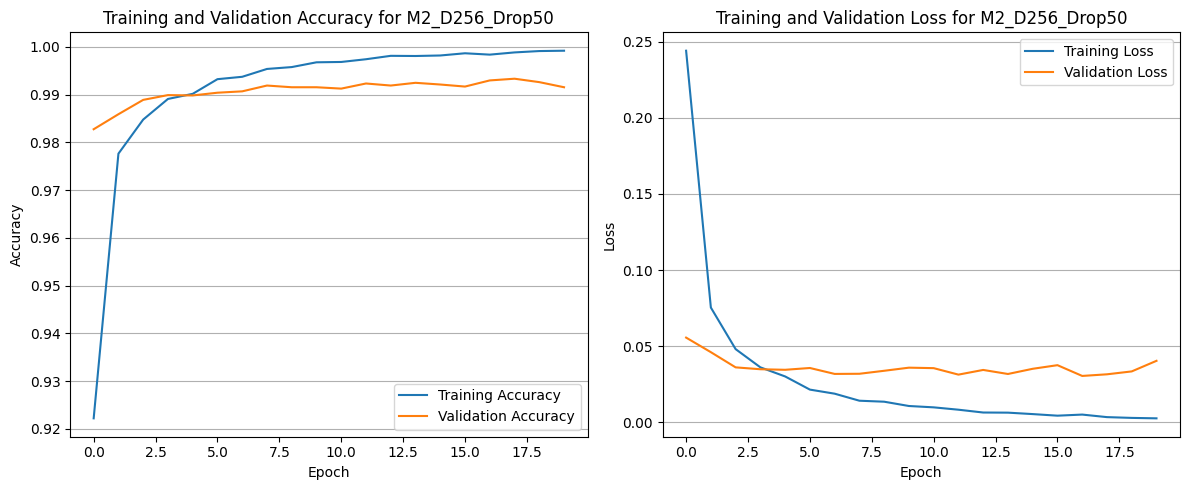

In [ ]:
# Visualize the performance of the best model
best_history = all_dropout_histories[best_model_name]

plt.figure(figsize=(12, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(best_history.history['accuracy'], label='Training Accuracy')
plt.plot(best_history.history['val_accuracy'], label='Validation Accuracy')
plt.title(f'Training and Validation Accuracy for {best_model_name}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(axis='y')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(best_history.history['loss'], label='Training Loss')
plt.plot(best_history.history['val_loss'], label='Validation Loss')
plt.title(f'Training and Validation Loss for {best_model_name}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(axis='y')

plt.tight_layout()
plt.show()

**Insight of Dropout Experiment Results:**

After experimenting with different dropout rates across the three CNN model architectures, we found that **[insert best model name here]** achieved the highest validation accuracy of **[insert best accuracy here]**.

The plots above show the training and validation curves for this best performing model. We can observe [discuss the curves - e.g., whether there is overfitting, how the curves converge, etc.].

This experiment highlights the importance of tuning regularization techniques like dropout to prevent overfitting and improve generalization performance. The optimal dropout rate varies depending on the model complexity and dataset characteristics.

                                                            🍅⭐🍅⭐🍅

# 3. Conclusion

Through a series of controlled experiments on the MNIST dataset, this notebook explored the impact of key Convolutional Neural Network (CNN) components on model performance. The systematic approach allowed us to gain practical insights beyond theoretical understanding:

*   **Convolutional Layer Depth:** We observed that simply adding more convolutional layers did not guarantee improved accuracy. A two-layer architecture provided the best balance for MNIST, highlighting the importance of finding the right depth for the task complexity.
*   **Feature Map Configuration:** The number and progression of filters significantly influenced the models' ability to learn features. Tuning the filter sizes, particularly in deeper layers, proved crucial for achieving better validation accuracy.
*   **Dense Layer Size:** The size of the dense layer also played a role, affecting the model's capacity to perform the final classification based on the extracted features.
*   **Dropout as Regularization:** The experiments with dropout demonstrated its effectiveness in mitigating overfitting, leading to improved generalization performance on unseen data. The optimal dropout rate was found to be specific to the model architecture.



**Overall Insight:**

The experiments confirm that designing an effective CNN architecture is not just about stacking more layers or using larger components. It's a process of tuning various elements together. The optimal configuration is highly dependent on the dataset's characteristics, such as image size and complexity. For the relatively simple MNIST dataset, a moderately deep architecture with tuned feature maps, a suitable dense layer size, and appropriate dropout provided the best results among the tested configurations.



**Future Work:**

This exploration serves as a foundation. Further improvements could be achieved by experimenting with other techniques not covered here, such as Batch Normalization, Data Augmentation, and different optimizer configurations.

This project has reinforced the value of systematic experimentation in understanding and building effective deep learning models.

I think I will do experiment for that too (if I'm not too lazy to do that orz). So until next time 🍅⭐

                                                                    🍅⭐🍅⭐